# Image Analysis of activity Assay

---

**Updated on:** 2024-05-14

> Authors: Simon Knoblauch (simon.knoblauch@student.uni-tuebingen.de)  
> Input file(s): .tif, .png, .jpg
> Images must contain visible circular wells or spots arranged in a grid  
> Output file(s): .csv file containing data on all detected spots

**Please read the comments before proceeding to run the code of each cell and let us know if you run into any errors or find undocumented pieces of code.**

In [6]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append(r"..")
from src.microspotreader import *
from src.streamlit.image_analysis.helper_functions import (
    get_first_colindex,
    get_first_rowindex,
    get_spot_nr,
)
%matplotlib widget

## User Input

Please input the filepath of the image you would like to analyze into `inputfile` as well as the path to the output folder into `outputfolder`.

In order to be able to merge multiple datasets containing data on the same LC-MS experiment (multiple assays per microfluidic device for example), please input the index of the top left (`first_spot`) and bottom right (`last_spot`) spot or well contained by the image correctly.

In [3]:
inputfile = Path(r"../example_files/part1_a1-l11.tif")
outputfolder = Path(r"../output")

first_spot = "A1"
last_spot = "L11"

## Loading the Image File

Here a grayscale version of the loaded image is displayed. If you want to invert the image colors for following analysis, please set the `invert_image` argument of the `img_loader.set` method to `True` otherwise set it to `False`.

(-0.5, 1209.5, 1443.5, -0.5)

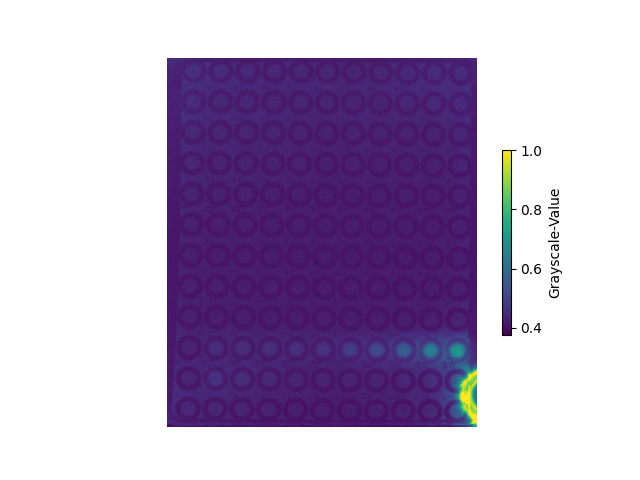

In [5]:
img_loader = ImageLoader()
img_loader.set(invert_image=True)
image = img_loader.prepare_image(inputfile)

fig, ax = plt.subplots()
img_plot = ax.imshow(image)
fig.colorbar(img_plot, shrink=0.5, label="Grayscale-Value")
ax.axis("off")

## Initial spot detection

For initial spot detection it is important that the settings `min_distance_px_x` (line 8, minimum distance of spots in x direction), `min_distance_px_y` (line 9, minimum distance of spots in y direction), `smallest_radius_px` (line 10, smallest tested radius of spots in pixels) and `largest_radius_px` (line 11, largest tested radius of spots in pixels) all match the image that you want to analyze. For one experimental setup this generally only has to be checked once. You can do this by hovering over the displayed version of the loaded image above and checking the coordinates of a spots center to its edge and the distance between two spots in x and y direction. The algorithm generally underestimates the radius of spots so set `smallest_radius_px` to a value slightly lower than you expect.

For noisy images the other settings of the method can also be tweaked to yield better results. All arguments containing the word ***canny*** are used for edge detection. The detected edges of the images are plotted next to the grid below this cell. it is important to check whether the edges clearly show circles. If that is not the case lower the thresholds for canny edge detection first. Note that the `low_threshold` setting (line 4) only accepts values *lower or equal* to the value of `high_threshold` (line 5).

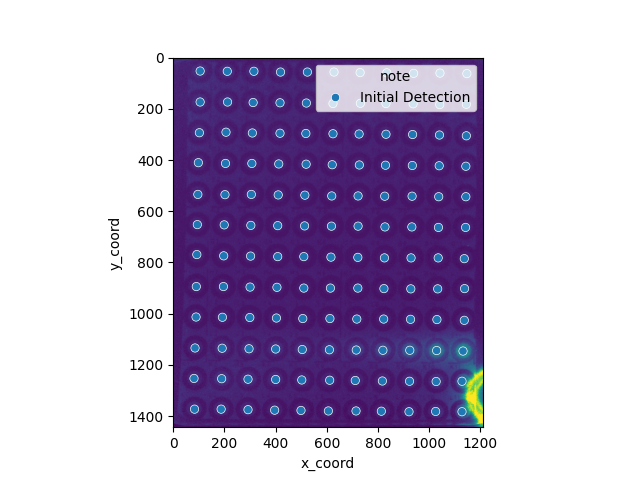

In [10]:
spot_detector_settings={
    "edge_detection": {
        "sigma": 10,
        "low_threshold": 0.001,
        "high_threshold": 0.001,
    },
    "circle_detection": {
        "min_distance_px_x": 70,
        "min_distance_px_y": 70,
        "smallest_radius_px": 20,
        "largest_radius_px": 30,
        "detection_threshold": 0.3,
    },
}

spot_detector = SpotDetector(image)
spot_detector.change_settings_dict(
    spot_detector_settings
)
spot_list = spot_detector.initial_detection(get_spot_nr(first_spot, last_spot))

fig,ax=plt.subplots()
ax.imshow(image)
spot_list.plot_scatter(ax)

## Grid detection
Grid detection is a step in the spot correction process. The most important setting is `minimum_distance_px` (line 4). Which defines the minimum distance 2 grid lines can have from each other. This should be very similar to the distances of spots to each other. Generally the value can be restricted a bit more than the ones for spot detection. To reduce the amount of artifacts, a maximum tilt of the grid can be defined in `maximum_tilt` (line 5). The lower the maximum tilt is the closer the grid has to be aligned with the primary axes of the image. The more relaxed the maximum tilt becomes, the more likely it is to see artifacts. We found that a tilt of around 4-5 degrees yields good results. If not all grid lines are detected we suggest first reducing the minimum distance between the grid lines before lowering the detection threshold with the `threshold` (line 5) setting.

Please cross-check if the grid detection worked properly by inspecting the plot below. If there is an intersection of grid lines on all spots, grid detection worked properly and you can continue with the next steps.

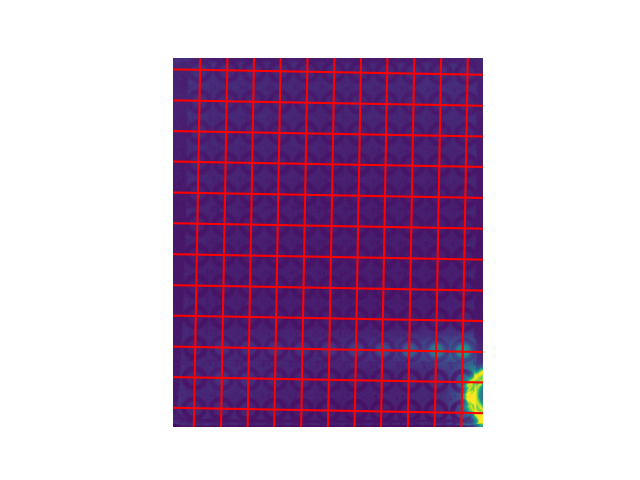

In [9]:
grid_detector_settings={
    "line_detection": {
        "maximum_tilt": 5,
        "minimum_distance_px": 80,
        "threshold": 0.2,
    },
    "spot_mask": {"spot_radius": 5},
}

grid_detector = GridDetector(image, spot_list)
grid_detector.change_settings_dict(
    grid_detector_settings
)
grid = grid_detector.detect_grid()

grid.plot_image(image)

## Spot Correction, Sorting and Intensity Determination

For this step only one setting should be tweaked: `distance_threshold_px` (line 10). This determines the maximum distance a detected spot can have from the detected grid in pixels to still be considered a valid spot. Any spot further away from the grid will be removed and any gridpoint that is not associated with a spot already will have a spot backfilled with the average radius of spots during initial spot detection. The smaller the max distance is, the more spots must adhere to the detected grid, this can be good if the grid detection is very reliable for the image. However initial spot detection can be better at finding the real center of a spot, which leads to a higher accuracy for the determination of the spot intensity. For our system a maximum distance of 10 pixels was found to work well.

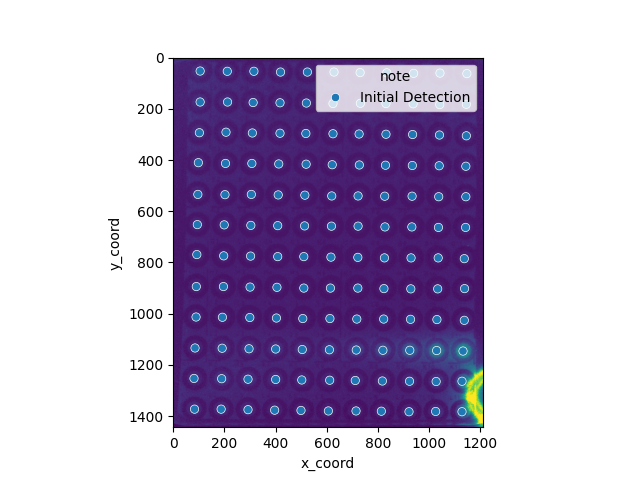

In [12]:
spot_corrector_settings={
    "general": {"spot_radius_backfill": 0},
    "from_grid": {"distance_threshold_px": 10},
}

spot_corrector = SpotCorrector(spot_list)
spot_corrector.change_settings_dict(
    spot_corrector_settings
)
spot_list = spot_corrector.gridbased_spotcorrection(grid)

# Indexing of spots
SpotIndexer(spot_list).assign_indexes(
    row_idx_start=get_first_rowindex(first_spot),
    col_idx_start=get_first_colindex(first_spot),
)
spot_list.sort(serpentine=False)
# Intensity determination of spots.
spot_list.get_spot_intensities(
    image=image,
    radius=0,
)

spot_list.normalize_by_median()

fig,ax=plt.subplots()
ax.imshow(image)
spot_list.plot_scatter(ax)

## Halo Detection

Halo detection is an optional step of the workflow. It is only needed if there are antimicrobial halos visible in the image. If you do not wish to perform halo detection, comment this cell out or skip this cell during analysis.

The quality of halo detection really depends on the image quality and is very sensitive to changes in the settings.

A range of radii that should be tested must be input via `smallest_radius_px` (line 10, smallest tested radius in pixels) and `largest_radius_px` (line 11, largest tested radius in pixels). Generally the lower input should be slightly higher than the radius of the spots themselves. The minimum distance in x and y direction (line 8 and 9, `min_distance_px_x` and `min_distance_px_y`) can take values similar to initial spot detection. It is also possible to lower the distance significantly as halos are already restricted to the location of spots in the images. This may lead to more false positive halos but can increase the reliability of halo detection if a proper value is found.

Another way to increase the reliability of halo detection is by increasing the `disk_radius_opening` (line 3) setting. This argument essentially defines the thickness of the halo skeleton after image processing. The thicker the halo skeleton the more likely it will be detected but the less accurate the determination of the radius becomes. The two settings we found work best are `3` for more reliable radius detection and `10` for more reliable halo detection.

After the halos have been detected they are assigned to a spot based on a distance criterium set by the `distance_threshold_px` setting (line 14). The larger this distance criterium is, the higher the likelihood of detecting halos for a given spot. However the likelihood of the detected halo being an artifact also increases. A decent approximation of a good distance criterium is half the maximum radius used during spot detection.

Spots with assigned halos will have their spot intensity replaces by a scaled down version of the halo radius. We found that a scaling factor of `0.04` works best for our set-up (line 24). If you do not wish to perform this step please comment out line 24.


In [13]:
halo_detector_settings={
    "preprocessing": {
        "disk_radius_opening": 5,
        "minimum_object_size_px": 800,
        "disk_radius_dilation": 10,
    },
    "circle_detection": {
        "min_distance_px_x": 70,
        "min_distance_px_y": 70,
        "smallest_radius_px": 40,
        "largest_radius_px": 100,
        "detection_threshold": 0.2,
    },
    "halo_assignment": {"distance_threshold_px": 15},
}

halo_detector = HaloDetector(image)

halo_detector.change_settings_dict(halo_detector_settings)

halo_detector.perform_halo_detection()
halo_detector.assign_halos_to_spots(spot_list)

spot_list.scale_halos_to_intensity(0.04)

## Results

c:\Users\nomis\OneDrive\Documents\2_Master\5_Labrotations\AK-Petras\1_Microspotter\MicrospotReader\notebooks\..\src\microspotreader\spot_classes\SpotList.py:276: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(


,row,row_name,column,type,x_coord,y_coord,radius,halo_radius,spot_intensity,raw_int,note
0,1,A,1,,105,52,24,NaN,1.060898,0.461616,Initial Detection
1,1,A,2,,211,53,25,96.0,3.840000,0.452249,Initial Detection
2,1,A,3,,315,53,24,NaN,1.031724,0.448922,Initial Detection
3,1,A,4,,419,56,25,NaN,1.026870,0.446810,Initial Detection
4,1,A,5,,524,56,25,NaN,1.016265,0.442196,Initial Detection
...,...,...,...,...,...,...,...,...,...,...,...
127,12,L,7,,714,1380,23,NaN,0.982613,0.427553,Initial Detection
128,12,L,8,,813,1381,23,NaN,0.989281,0.430455,Initial Detection
129,12,L,9,,921,1383,25,NaN,0.997627,0.434086,Initial Detection
130,12,L,10,,1025,1382,23,NaN,1.025179,0.446074,Initial Detection


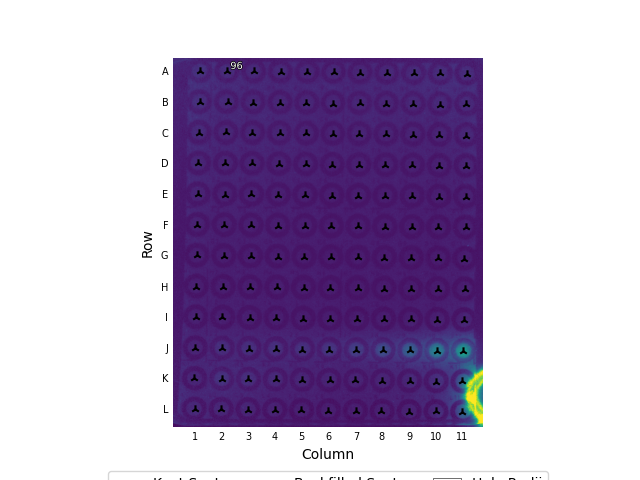

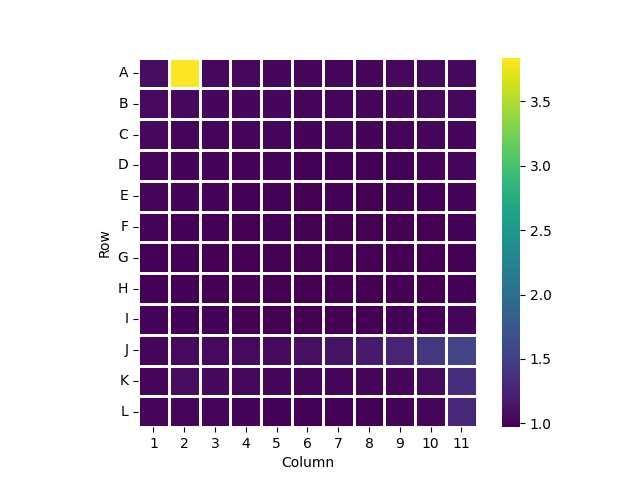

In [14]:
spot_df=spot_list.to_df()

spot_list.plot_image(image)

spot_list.plot_heatmap()

spot_df

## Save Results

Run this cell to save the resulting table as a `.csv` file.

In [ ]:
if not outputfolder.exists():
    outputfolder.mkdir()

# Generate path for output-file
filename = inputfile.name.split(".")[0] + "_spotlist.csv"
outputfile = outputfolder / filename

# Write a csv-file of the results.
spot_df.to_csv(outputfile)